In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 

import time
import torch
from torch.utils.data import Dataset , DataLoader

from  sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [2]:
df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

print(df.shape, test_df.shape)


(42000, 785) (28000, 784)


In [3]:
class MNIST_dataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return(len(self.df))
        
    def __getitem__(self, idx):
        img_data = self.df.iloc[idx,1:].values.reshape((1,28,28)).astype(np.float32) / 255.
        label = self.df.iloc[idx, 0]
        return img_data, label
    
    
    

In [4]:
train_df , valid_df = train_test_split(df, test_size=0.2, random_state=1)

In [5]:
from torch import nn

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.4),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.4),         

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.4),
            
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(3*3*128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.4),
            nn.Linear(256, 10),
        )
            
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return(x)
    

In [6]:
from torch import optim
from tqdm.auto import tqdm

In [7]:
 criterion = nn.CrossEntropyLoss()

In [8]:
def train_one_epoch(dl, epoch_num, model, optimizer):
    
    total_loss = 0.0
    for X, y in dl:
        
        optimizer.zero_grad()
        
        y1 = model(X.cuda())
        loss = criterion(y1, y.cuda())
        
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.detach().item()
        
    # print(f'epoch : {epoch_num}, Loss : {total_loss/len(dl.dataset):.6f}')
        

In [9]:
def evaluate(dl, model, optimizer):
    total_loss = 0.0
    total_correct = 0.0
    
    with torch.no_grad():
        for X,y in dl :
            y1 = model(X.cuda())
            loss = criterion(y1,y.cuda())
            pred = torch.argmax(y1, dim=1).cpu()
            
            total_loss += loss.item()
            total_correct += torch.sum(y==pred).float().item()
            
        accuracy = total_correct/len(dl.dataset)
        
    # print(f'Loss : {total_loss/len(dl.dataset):.6f}, Accuracy : {accuracy*100:.3f}%')
    return accuracy
            

Running the Batch_size : 32



481.14195132255554 seconds
Running the Batch_size : 64



393.83004117012024 seconds
Running the Batch_size : 128



369.55148911476135 seconds
Running the Batch_size : 256



359.61715865135193 seconds
Running the Batch_size : 512



353.1730766296387 seconds
Running the Batch_size : 1024



350.4000961780548 seconds


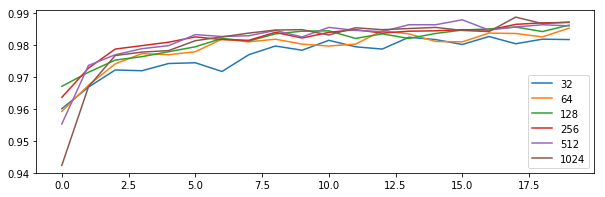

In [10]:
batch_size_list = [32, 64, 128, 256, 512, 1024]
accuracies = {}
for batch_size in batch_size_list:
    
        t0 = time.time()

        print(f'Running the Batch_size : {batch_size}') 
        
        train_dl = DataLoader(MNIST_dataset(train_df), batch_size=batch_size)
        valid_dl = DataLoader(MNIST_dataset(valid_df), batch_size=batch_size)
        
        model = Model().cuda()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        curr_acc_list = []
        epoch_num = 20
        for epoch in tqdm(range(epoch_num)):
            train_one_epoch(train_dl, epoch, model, optimizer)
            acc = evaluate(valid_dl, model, optimizer)
            curr_acc_list.append(acc)
        
        accuracies[batch_size] = curr_acc_list
        del model
        torch.cuda.empty_cache()
        
        print('{} seconds'.format(time.time() - t0))
              
plt.figure(figsize=(10, 3))
for k, v in accuracies.items():
    plt.plot(v, label=k)
plt.legend()    

In [11]:
for k, v in accuracies.items():
    print(k, v)
    print()

32 [0.9601190476190476, 0.9669047619047619, 0.9722619047619048, 0.9720238095238095, 0.9742857142857143, 0.9745238095238096, 0.9717857142857143, 0.9770238095238095, 0.9797619047619047, 0.978452380952381, 0.981547619047619, 0.9795238095238096, 0.9788095238095238, 0.9825, 0.9817857142857143, 0.9802380952380952, 0.9827380952380952, 0.9804761904761905, 0.981904761904762, 0.9817857142857143]

64 [0.9592857142857143, 0.9675, 0.9741666666666666, 0.9773809523809524, 0.9770238095238095, 0.9779761904761904, 0.981904761904762, 0.9810714285714286, 0.981904761904762, 0.9803571428571428, 0.9797619047619047, 0.9803571428571428, 0.9845238095238096, 0.9835714285714285, 0.9811904761904762, 0.9810714285714286, 0.9838095238095238, 0.9836904761904762, 0.9826190476190476, 0.9853571428571428]

128 [0.9671428571428572, 0.971547619047619, 0.9753571428571428, 0.9764285714285714, 0.9779761904761904, 0.9795238095238096, 0.9821428571428571, 0.9813095238095239, 0.9835714285714285, 0.9844047619047619, 0.9845238095238